<div style="background-color:lightgreen; border-style: dotted;border-color: yellow;text-align:center;color:blue;font-size:20px;border-radius: 50px;padding: 20px 20px;"><strong> Gashaw M. Goshu, PhD in Chemistry</strong></div>

# HOMO-LUMO Energy Gap Prediction using RDKit Molecular descriptors

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#----------------------------------------------------
import pandas as pd
import numpy as np
#----------------------------------------------------
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
#----------------------------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
#----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
#----------------------------------------------------
# 42 ML models
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [2]:
import session_info
session_info.show()

In [3]:
# https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool
# It was an excel file, but converted it to csv file 
# It is the energy gap between HOMO-LUMO
dataset = pd.read_csv('D:\Orbital_Energies_input_data.csv')
dataset.shape

(2904, 2)

In [4]:
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.75
1,OC(=O)CCCCl,247.49
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.71
3,Nc1ccc(Cl)c(Cl)c1,169.03
4,C[C@@H](CCO)CCC=C(C)C,209.57


## 1. Generate canonical SMILES

In [5]:
# There might be one or more valid SMILES that can represent one compound
# Thanks to Pat Walters this information:
# https://www.blogger.com/profile/18223198920629617711
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

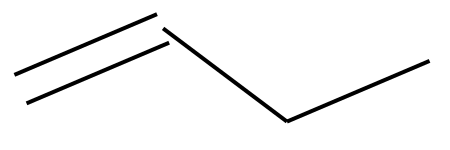

In [6]:
a = Chem.MolFromSmiles('C=CCC')
a

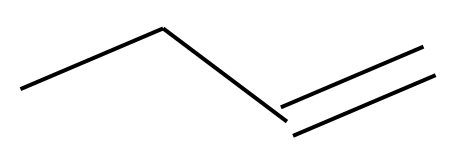

In [7]:
b = Chem.MolFromSmiles('CCC=C')
b

In [8]:
a==b

False

In [9]:
c = canonical_smiles(['C=CCC'])
c

['C=CCC']

In [10]:
d = canonical_smiles(['CCC=C'])
d

['C=CCC']

In [11]:
c==d

True

In [12]:
# Canonical SMILES
Canon_SMILES = canonical_smiles(dataset.SMILES)
len(Canon_SMILES)

2904

In [13]:
# Put the smiles in the dataframe
dataset['SMILES'] = Canon_SMILES
dataset

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.75
1,O=C(O)CCCCl,247.49
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.71
3,Nc1ccc(Cl)c(Cl)c1,169.03
4,CC(C)=CCC[C@@H](C)CCO,209.57
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.65
2900,Brc1cccc2sccc12,162.93
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.10
2902,c1ccc2sccc2c1,167.96


In [14]:
# Create a list for duplicate smiles
duplicates_smiles = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
len(duplicates_smiles)

31

In [15]:
# Create a list for duplicate smiles
dataset[dataset['SMILES'].isin(duplicates_smiles)].sort_values(by=['SMILES'])

,SMILES,Energygap
218,C1=CCCCCCC1,214.10
2125,C1=CCCCCCC1,214.10
1901,C1CC[C@H]2CCCC[C@@H]2C1,251.14
552,C1CC[C@H]2CCCC[C@@H]2C1,251.14
554,C=CN1CCCC1=O,190.83
1808,C=CN1CCCC1=O,190.84
2203,C=Cc1ccccc1,168.47
1354,C=Cc1ccccc1,168.48
2341,C=Cc1ccccc1,168.49
1265,C=Cc1ccncc1,174.83


## 2.  Drop duplicate values

In [16]:
dataset_new = dataset.drop_duplicates(subset=['SMILES'])
len(dataset_new)

2873

In [17]:
dataset_new

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.75
1,O=C(O)CCCCl,247.49
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.71
3,Nc1ccc(Cl)c(Cl)c1,169.03
4,CC(C)=CCC[C@@H](C)CCO,209.57
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.65
2900,Brc1cccc2sccc12,162.93
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.10
2902,c1ccc2sccc2c1,167.96


## Calculate descriptors using RDkit

###  General molecular descriptors-about 200 molecular descriptors

In [18]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(dataset_new['SMILES'])

In [19]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.55,-5.08,12.55,1.01,0.55,160.14,153.08,160.05,60,0,...,0,0,0,0,0,0,0,0,0,0
1,10.68,-3.33,10.68,1.84,0.57,122.55,115.49,122.01,42,0,...,0,0,0,0,0,0,0,0,0,0
2,13.05,-4.11,13.05,0.72,0.79,361.82,341.67,361.11,132,0,...,0,0,0,0,0,0,0,0,0,0
3,7.40,-0.45,7.40,0.07,0.58,162.02,156.98,160.98,48,0,...,0,0,0,0,0,0,0,0,0,0
4,8.10,-4.48,8.10,1.89,0.61,156.27,136.11,156.15,66,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.51,-3.87,9.51,0.97,0.37,398.43,374.23,398.14,138,0,...,0,0,0,0,0,0,0,0,0,0
2869,7.65,-0.17,7.65,0.02,0.63,213.10,208.06,211.93,50,0,...,0,0,0,0,0,0,0,1,0,0
2870,13.02,-3.81,13.02,0.33,0.82,247.29,230.16,247.12,96,0,...,0,0,0,0,0,0,0,0,0,0
2871,7.59,-0.35,7.59,0.03,0.52,134.20,128.15,134.02,44,0,...,0,0,0,0,0,0,0,1,0,0


## Remove highly correlated features

In [20]:
def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(np.bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped    

In [21]:
descriptors_new = remove_correlated_features(df_with_200_descriptors)
descriptors_new

['MaxAbsEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi3n', 'Chi4n', 'Chi4v', 'LabuteASA', 'SlogP_VSA5', 'SlogP_VSA6', 'EState_VSA1', 'VSA_EState1', 'HeavyAtomCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'MolMR', 'fr_COO2', 'fr_C_O', 'fr_Nhpyrrole', 'fr_benzene', 'fr_nitro_arom', 'fr_phenol', 'fr_phenol_noOrthoHbond']


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.55,-5.08,1.01,0.55,160.14,60,0,0.42,-0.17,1.00,...,0,0,0,0,0,0,0,0,0,0
1,10.68,-3.33,1.84,0.57,122.55,42,0,0.30,-0.48,2.14,...,0,0,0,0,0,0,0,0,0,0
2,13.05,-4.11,0.72,0.79,361.82,132,0,0.35,-0.48,1.12,...,0,0,0,0,0,0,0,0,0,0
3,7.40,-0.45,0.07,0.58,162.02,48,0,0.16,-0.40,1.22,...,0,0,0,0,0,0,0,0,0,0
4,8.10,-4.48,1.89,0.61,156.27,66,0,0.21,-0.40,1.45,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.51,-3.87,0.97,0.37,398.43,138,0,0.06,-0.06,0.36,...,0,0,0,0,0,0,0,0,0,0
2869,7.65,-0.17,0.02,0.63,213.10,50,0,0.07,-0.14,1.20,...,0,0,0,0,0,0,0,1,0,0
2870,13.02,-3.81,0.33,0.82,247.29,96,0,0.42,-0.45,1.33,...,0,0,0,0,0,0,0,0,0,0
2871,7.59,-0.35,0.03,0.52,134.20,44,0,0.07,-0.14,1.00,...,0,0,0,0,0,0,0,1,0,0


In [22]:
y = dataset_new.Energygap
len(y)

2873

## Train-test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(descriptors_new,y,test_size=0.2,random_state=42)

## Each feature will be scaled using:
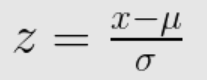

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Let us train and identify best ML models for this problem

In [25]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models, prediction_tests = lregs.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:22<00:00,  1.89it/s]


In [26]:
prediction_tests[:3]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.88,0.91,9.02,0.17
HistGradientBoostingRegressor,0.88,0.91,9.04,3.61
ExtraTreesRegressor,0.87,0.91,9.16,2.34


In [27]:
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
import skopt
from skopt import gp_minimize
from skopt import BayesSearchCV

In [28]:
lgbm = LGBMRegressor()
gbr = HistGradientBoostingRegressor()

In [29]:
# Ten fold cross-validation
def cross_val(model):
    #RMSE
    score = cross_val_score(model,X_train, y_train,scoring="neg_mean_squared_error", cv=5)
    RMSE_score = np.sqrt(-score)
    RMSE_mean = RMSE_score.mean()
    RMSE_std = RMSE_score.std()
    # R2
    r2 = cross_val_score(model,X_train, y_train,scoring="r2", cv=5)
    r2_mean = r2.mean()
    r2_std = r2.std()
    return RMSE_score,RMSE_mean,RMSE_std,r2,r2_mean,r2_std

In [30]:
# Call the function and get the variables
RMSE_score_lgbm, RMSE_mean_lgbm, RMSE_std_lgbm, r2_lgbm,r2_mean_lgbm, r2_std_lgbm = cross_val(lgbm)
RMSE_score_gbr, RMSE_mean_gbr, RMSE_std_gbr, r2_gbr, r2_mean_gbr, r2_std_gbr = cross_val(gbr)

In [31]:
lbgm_RMSE_info = np.append(RMSE_score_lgbm,[RMSE_mean_lgbm,RMSE_std_lgbm])
lbgm_R2_info = np.append(r2_lgbm,[r2_mean_lgbm,r2_std_lgbm])

In [32]:
lbgm_df = pd.DataFrame([lbgm_RMSE_info,lbgm_R2_info],columns=[i+1 for i in range(len(lbgm_RMSE_info))])
lbgm_df

,1,2,3,4,5,6,7
0,9.44,9.52,8.80,9.93,10.31,9.60,0.51
1,0.90,0.90,0.92,0.90,0.89,0.90,0.01


In [33]:
lbgm_df.rename(index={0:'RMSE',1:'R2'}, columns={6:'Avg',7:'std'})

,1,2,3,4,5,Avg,std
RMSE,9.44,9.52,8.80,9.93,10.31,9.60,0.51
R2,0.90,0.90,0.92,0.90,0.89,0.90,0.01


In [34]:
# Put the five-fold cross-validation in dataframe
gbr_RMSE_info = np.append(RMSE_score_gbr,[RMSE_mean_gbr,RMSE_std_gbr])
lbgm_R2_info = np.append(r2_gbr,[r2_mean_gbr,r2_std_gbr])

gbr_df = pd.DataFrame([gbr_RMSE_info,lbgm_R2_info],columns=[i+1 for i in range(len(lbgm_RMSE_info))])
gbr_df.rename(index={0:'RMSE',1:'R2'}, columns={6:'Avg',7:'std'})

,1,2,3,4,5,Avg,std
RMSE,9.62,9.51,8.87,9.86,10.37,9.64,0.49
R2,0.90,0.90,0.91,0.90,0.89,0.90,0.01


In [ ]:
# Define search space
params = dict()
params['max_depth'] = (np.arange(2,8,1))
params['min_samples_split'] = (np.arange(2,5,1))
params['n_estimators'] = (np.arange(100,1000,100))
params['max_features'] = ("auto", "sqrt", "log2")

In [ ]:
# # define the Bayes search using Sklearn
# search = BayesSearchCV(estimator=lgbm, search_spaces=params,cv=10)
# # perform the search
# search.fit(X_train, y_train)
# #Print the best result
# print(search.best_score_)
# print(search.best_params_)

## Use the optimized parameters to predict test sets


In [49]:
# define LGBMRegressor model
lgbm_opt =LGBMRegressor(max_depth=5,min_samples_split=2, n_estimators= 900,max_features='log2')

In [52]:
gbr_opt = HistGradientBoostingRegressor()#learning_rate= 0.15

In [53]:
# train the model and predict the yield using X_test 
lgbm_opt.fit(X_train, y_train)
lgbm_predict = lgbm_opt.predict(X_test)
# train the model and predict the yield using X_test 
gbr_opt.fit(X_train, y_train)
gbr_predict = gbr_opt.predict(X_test)

In [54]:
# Take the average of the optimized predictions
ave_predict = (lgbm_predict + gbr_predict)/2

In [55]:
# model performance using RMSE
rmse = np.sqrt(mean_squared_error(y_test, ave_predict))  
print('rmse:', rmse)

rmse: 8.6653104981398


In [56]:
df_ = pd.DataFrame()

In [57]:
df_['Actual'] = np.array(y_test)
df_['Predicted'] = ave_predict

In [58]:
df_

,Actual,Predicted
0,189.29,187.12
1,199.23,197.65
2,169.53,169.35
3,219.88,222.55
4,211.16,207.90
...,...,...
570,180.30,194.42
571,165.88,165.64
572,184.56,191.77
573,200.32,193.10


In [59]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(y_test, ave_predict)
print('R^2:', R2)

R^2: 0.9192856073734402


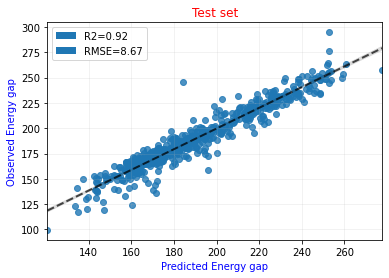

In [60]:
sn.regplot(x=ave_predict , y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Test set", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
plt.legend(handles=[R2, rmse])

## Save your model

In [61]:
import pickle
with open('lgbm_model.pkl','wb') as f:
          pickle.dump(lgbm_opt,f)
        
with open('hgbr_model.pkl','wb') as f:
          pickle.dump(gbr_opt,f)

##  Load your model

In [62]:
with open('lgbm_model.pkl','rb') as f:
    model_lgbm = pickle.load(f)
        
with open('hgbr_model.pkl','rb') as f:
    model_hgbr = pickle.load(f)